### Amazon product review data processing

We use this website to get data: http://jmcauley.ucsd.edu/data/amazon/

Given that we want to test the power of transfer learning with the idea that it could prove useful to pretrain networks on review categories with lots of data to improve prediction performance on categories with less data, we choose the Amazon product category with the largest amount of data - books.

We download the file from the section labeled _"Small" subsets for experimentation_ with the title  _Books	5-core (8,898,041 reviews)_.

The file is saved in the data directory, but not tracked in this Github repository due to filesize limitations. The downloaded file name is `reviews_Books_5.json.gz`. It can be downloaded to the correct location from here with the following command:

In [ ]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz -P ./data/amazon
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz -P ./data/amazon
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz -P ./data/amazon
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_CDs_and_Vinyl_5.json.gz -P ./data/amazon
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Kindle_Store_5.json.gz -P ./data/amazon

In [1]:

import gzip
import json
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import shutil
import time

The following code extracts the zipfile:

In [ ]:
zip_files = [
    "reviews_Books_5.json.gz",
    "reviews_Electronics_5.json.gz",
    "reviews_Movies_and_TV_5.json.gz",
    "reviews_CDs_and_Vinyl_5.json.gz",
    "reviews_Kindle_Store_5.json.gz",
    ]
for zf in zip_files:
    zip_fp = os.path.join(os.getcwd(), "data", "amazon", zf)
    out_fp = os.path.join(os.getcwd(), "data", "amazon", zf[:-3])
    with gzip.open(zip_fp, "rb") as f_in:
        with open(out_fp, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

We know that there are almost 9m records, therefore trying to load the whole file into memory may cause out-of-memory errors. Since we don't need the whole file, only < 100k records, we iterate through the whole file and randomly select approximately 5% of eligible records for a sample, which will then be loaded into memory to randomly select the final data sample for training, test, and validation. We save part files every 50,000 records so the list doesn't get too large and slow things down.

For eligibility, as per the Bilal paper, we discard reviews with 1, 2, or 3 helpful ratings, leaving only those with 0 helpful ratings (to be classified as "unhelpful") and those with 4 or more helpful ratings (to be classified as "helpful").

We also found a very small number of bad data issues where the number of helpful reviews was greater than the total number of reviews, so these are also discarded. Additionally there were a handful of rows where the `reviewText` field was empty, so these are also discarded since they can't be used in a language model.

In [4]:
out_files = [
    # "reviews_Books_5.json",
    "reviews_Electronics_5.json",
    "reviews_Movies_and_TV_5.json",
    "reviews_CDs_and_Vinyl_5.json",
    "reviews_Kindle_Store_5.json",
]
# Take a different fraction for each category since population sizes are different,
# and we need at least 50k records of each.
fractions = [
    # 5, 
    20, 
    20, 
    20, 
    50
]
for f, fraction in zip(out_files, fractions):
    
    out_fp = os.path.join(os.getcwd(), "data", "amazon", f)
    category = f.split(".")[0].split("reviews_")[1]

    with open(out_fp, "r") as f:
        
        print(f"Category: {category}")

        # Initialize counters:
        t1 = time.time()
        sample_data = list()
        selected, saved = 0, False
        part = 1
        eligible = 0

        # Use a generator with random seeds to select records so results are reproducible:
        random.seed(42)
        rand_gen = (random.randint(1, 100) for _ in range(1_000_000_000))

        # Iterate through all reviews:
        for i, line in enumerate(f):

            # Print progress update:
            if not i % 1000:
                elapsed = f"{time.time() - t1:,.1f}"
                print(f"> Selected {selected:,.0f} records of {i:,.0f} "
                      f"({eligible:,.0f} eligible) "
                      f"in {elapsed} seconds", end="\r")

            # As per the paper if the review contains 1/2/3 helpful votes, we
            # discard it from consideration:
            data = eval(line)
            helpful_num, helpful_denom = data["helpful"]
            discard = helpful_num >= 1 and helpful_num <= 3
            bad_data = helpful_num > helpful_denom
            bad_review = (not isinstance(data["reviewText"], str)) or (not len(data["reviewText"]))
            if discard or bad_data or bad_review:
                continue
            eligible += 1

            # Randomly select 5% of records:
            if next(rand_gen) <= fraction:  
                selected += 1
                sample_data.append(data)
                saved = False
            else:
                continue        

            # Save the part file:
            if (not selected % 50_000) and (selected != 0) and (not saved):
                pt = f"{part:.0f}".zfill(3)
                part_name = f"SAMPLE_pt{pt}_reviews_{category}.json"
                part_fp = os.path.join(os.getcwd(), "data", "amazon", part_name)
                with open(part_fp, "w") as part_f:
                    json.dump(sample_data, part_f)
                part += 1
                sample_data = list()
                saved = True

    # Save the last part:
    if len(sample_data):
        pt = f"{part:.0f}".zfill(3)
        part_name = f"SAMPLE_pt{pt}_reviews_{category}.json"
        part_fp = os.path.join(os.getcwd(), "data", "amazon", part_name)
        with open(part_fp, "w") as part_f:
            json.dump(sample_data, part_f)

    # Print final status:
    elapsed = f"{time.time() - t1:,.1f}"
    print(f"> Selected {selected:,.0f} records of {i:,.0f} "
          f"({eligible:,.0f} eligible) "
          f"in {elapsed} seconds", end="\n")

Category: Electronics_5
> Selected 251,152 records of 1,689,187 (1,254,320 eligible) in 69.1 seconds
Category: Movies_and_TV_5
> Selected 224,333 records of 1,697,532 (1,120,770 eligible) in 80.5 seconds
Category: CDs_and_Vinyl_5
> Selected 134,137 records of 1,097,591 (669,225 eligible) in 51.4 seconds
Category: Kindle_Store_5
> Selected 321,658 records of 982,618 (643,270 eligible) in 41.8 seconds


Now we load the full samples into a single pandas DataFrame to do some EDA.

In [5]:
df = pd.DataFrame()

files = [f for f in os.listdir(os.path.join(os.getcwd(), "data", "amazon")) if "SAMPLE_pt" in f]
for part_name in files:
    category = part_name.split(".")[0].split("reviews_")[1]
    part_fp = os.path.join(os.getcwd(), "data", "amazon", part_name)
    with open(part_fp, "r") as part_file:
        part_data = json.load(part_file)
        part_df = pd.DataFrame(part_data)
        part_df["category"] = category
        df = df.append(part_df).reset_index(drop=True)
        
# Separate out the helpful numerator and denominator:
df["helpful_numerator"] = [h[0] for h in df["helpful"]]
df["helpful_denominator"] = [h[1] for h in df["helpful"]]

# Add the classification of helpful/unhelpful and check the distribution:
df["helpful_category"] = np.where(df["helpful_numerator"] == 0, "unhelpful", "helpful")
df["helpful_category"].value_counts(normalize=True)

unhelpful    0.780834
helpful      0.219166
Name: helpful_category, dtype: float64

In [6]:
# Overall counts of helpful votes (numerator) and total votes (denominator):
df[["helpful_numerator", "helpful_denominator"]].sum()

helpful_numerator      4072984
helpful_denominator    5282408
dtype: int64

In [7]:
# Overall helpfulness ratio:
df["helpful_numerator"].sum() / df["helpful_denominator"].sum()

0.7710468407589872

<AxesSubplot:ylabel='Frequency'>

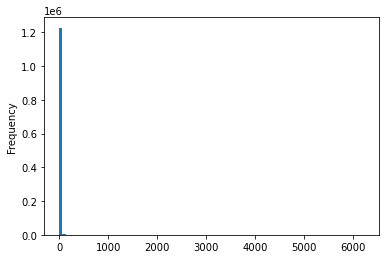

In [8]:
# Distribution of numerator:
df["helpful_numerator"].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

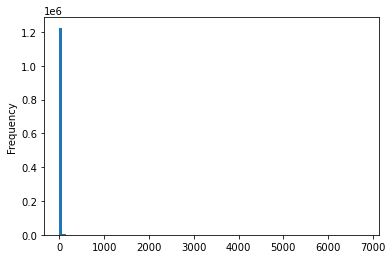

In [9]:
# Distribution of denominator:
df["helpful_denominator"].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

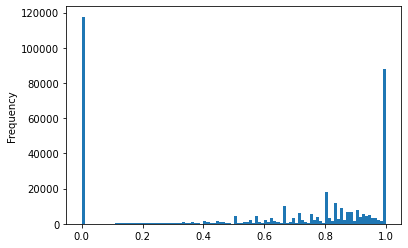

In [10]:
df["helpful_ratio"] = df["helpful_numerator"] / df["helpful_denominator"]
df["helpful_ratio"].plot.hist(bins=100)

In [11]:
len(df[df["helpful_ratio"] > 0.5])

245935

In [12]:
df["helpful_category"].value_counts()

unhelpful    965275
helpful      270936
Name: helpful_category, dtype: int64

In [13]:
review_lengths = [len(s) for s in df["reviewText"]]

In [14]:
max(review_lengths)

32519

In [15]:
min(review_lengths)

1

In [16]:
sum(review_lengths) / len(review_lengths)

723.261534640931

<AxesSubplot:ylabel='Frequency'>

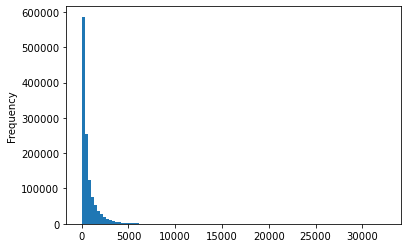

In [17]:
pd.Series(review_lengths).plot.hist(bins=100)

## Create train and test data

We have a big class imbalance in our dataset, we'll correct this by doing some undersampling on the negative class.

In [18]:
balanced_df = pd.DataFrame()

for category, subset in df.groupby("category"):
    
    # Find out how many positive labels we have:
    positive_samples = subset[(subset["helpful_category"] == "helpful")]
    n_positive_samples = positive_samples.shape[0]

    # Sample from negative class so we have the same amount:
    negative_samples = subset[(subset["helpful_category"] == "unhelpful")
                             ].sample(n=n_positive_samples, random_state=42)

    balanced_subset = positive_samples.append(negative_samples)
    balanced_df = balanced_df.append(balanced_subset)

# Add the label in binary form:
balanced_df["label"] = balanced_df["helpful_category"].map({"unhelpful": 0, "helpful": 1})

# # Save just the X-y columns of the full balanced dataset:
# fp = os.path.join(os.getcwd(), "data", "amazon", "full_balanced.csv")
# balanced_df[["reviewText", "label"]].to_csv(fp, encoding="utf-8", index=False)

# Check balance:
print("Balance = ", balanced_df["label"].mean())

# Check numbers in each category (want at least 50k each):
balanced_df["category"].value_counts()

Balance =  0.5


Books_5            139452
Movies_and_TV_5    136742
CDs_and_Vinyl_5    118232
Electronics_5       79802
Kindle_Store_5      67644
Name: category, dtype: int64

Next we take a random sample of 50k rows from each category:

In [20]:
sampled_df = pd.DataFrame()

for category, subset in balanced_df.groupby("category"):
    
    category_sample = subset.sample(n=50_000, random_state=42)
    sampled_df = sampled_df.append(category_sample)

# Check balance:
print("Balance = ", sampled_df["label"].mean())

# Check numbers in each category (want at least 50k each):
sampled_df["category"].value_counts()

Balance =  0.499912


Books_5            50000
CDs_and_Vinyl_5    50000
Electronics_5      50000
Kindle_Store_5     50000
Movies_and_TV_5    50000
Name: category, dtype: int64

Finally we randomly split into train (80% of records) and test and validation (10% each).

In [21]:
indices = list(sampled_df.index)
random.seed(42)
random.shuffle(indices)

train_size = int(len(sampled_df) * 0.8)
train_ix = indices[:train_size]
test_val_size = int(len(sampled_df) * 0.1)
val_ix = indices[train_size:train_size+test_val_size]
test_ix = indices[train_size+test_val_size:]

train = sampled_df.loc[train_ix]
val = sampled_df.loc[val_ix]
test = sampled_df.loc[test_ix]

print(f"Train:  {len(train)}")
print(f"Valid:  {len(val)}")
print(f"Test:   {len(test)}")

Train:  200000
Valid:  25000
Test:   25000


A final balance check on the data splits:

In [23]:
# Check balance:
print("Balance = ", train["label"].mean())

# Check numbers in each category (want at least 50k each):
train["category"].value_counts()

Balance =  0.500425


CDs_and_Vinyl_5    40204
Movies_and_TV_5    40076
Electronics_5      39970
Books_5            39893
Kindle_Store_5     39857
Name: category, dtype: int64

In [24]:
# Check balance:
print("Balance = ", val["label"].mean())

# Check numbers in each category (want at least 50k each):
val["category"].value_counts()

Balance =  0.49384


Books_5            5081
Movies_and_TV_5    5066
Kindle_Store_5     5022
Electronics_5      4970
CDs_and_Vinyl_5    4861
Name: category, dtype: int64

In [25]:
# Check balance:
print("Balance = ", test["label"].mean())

# Check numbers in each category (want at least 50k each):
test["category"].value_counts()

Balance =  0.50188


Kindle_Store_5     5121
Electronics_5      5060
Books_5            5026
CDs_and_Vinyl_5    4935
Movies_and_TV_5    4858
Name: category, dtype: int64

Since the process should be reproducible due to using random seeds, the following can be used as a rough checksum to make sure results match. The numbers should read:

* Train checksum = 255886169904000
* Test checksum = 32036536972800
* Validation checksum = 32027365267200

In [26]:
print(f"Train checksum      = {sum(train['unixReviewTime'])}")
print(f"Test checksum       = {sum(test['unixReviewTime'])}")
print(f"Validation checksum = {sum(val['unixReviewTime'])}")

Train checksum      = 255886169904000
Test checksum       = 32036536972800
Validation checksum = 32027365267200


In [36]:
fp = os.path.join(os.getcwd(), "data", "amazon", "train_LARGE.csv")
train.to_csv(fp, encoding="utf-8", index=False)
fp = os.path.join(os.getcwd(), "data", "amazon", "val_LARGE.csv")
val.to_csv(fp, encoding="utf-8", index=False)
fp = os.path.join(os.getcwd(), "data", "amazon", "test_LARGE.csv")
test.to_csv(fp, encoding="utf-8", index=False)